In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


In [ ]:
# Load datasets
links_df = pd.read_csv(r'c:\Users\swapna\Desktop\major project\dataset\ml-latest-small\links.csv')
movies_df = pd.read_csv(r'c:\Users\swapna\Desktop\major project\dataset\ml-latest-small\movies.csv')
ratings_df = pd.read_csv(r'c:\Users\swapna\Desktop\major project\dataset\ml-latest-small\ratings.csv')
tags_df = pd.read_csv(r'c:\Users\swapna\Desktop\major project\dataset\ml-latest-small\tags.csv')



In [ ]:

# Merge movies and tags data
movies_tags_df = pd.merge(movies_df, tags_df, on='movieId', how='left')

# Combine tags for each movie
movies_tags_df['combined_tags'] = movies_tags_df.groupby('movieId')['tag'].transform(lambda x: ' '.join(x.fillna('')))

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform TF-IDF vectorizer
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_tags_df['combined_tags'])

# Calculate cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to recommend movies based on user's rated movies
def recommend_movies(user_id, ratings_df, movies_tags_df, cosine_sim, n_recommendations=5):
    # Get movies rated by the user
    user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId']

    # Initialize movie scores
    movie_scores = {}

    # Iterate over each movie rated by the user
    for movie_id in user_rated_movies:
        # Get index of the movie in the movies dataframe
        movie_idx = movies_tags_df[movies_tags_df['movieId'] == movie_id].index[0]

        # Get similarity scores of all movies with respect to the current movie
        sim_scores = list(enumerate(cosine_sim[movie_idx]))

        # Sort movies based on similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get top N similar movies
        top_similar_movies = sim_scores[1:n_recommendations+1]

        # Update movie scores
        for idx, score in top_similar_movies:
            movie_id = movies_tags_df.iloc[idx]['movieId']
            if movie_id not in movie_scores:
                movie_scores[movie_id] = score
            else:
                movie_scores[movie_id] += score

    # Sort movies based on scores
    recommended_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)

    return [movie[0] for movie in recommended_movies[:n_recommendations]]
# Function to calculate precision and recall for overall recommendations
def calculate_precision_recall(ratings_df, recommended_movies, n_recommendations=5):
    # Initialize variables to store precision and recall
    precision_sum = 0
    recall_sum = 0

    # Iterate over each user
    for user_id in ratings_df['userId'].unique():
        # Get movies rated by the user
        actual_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        # Get recommended movies for the user
        recommended_movies_user = recommend_movies(user_id, ratings_df, movies_tags_df, cosine_sim, n_recommendations)

        # Limit the number of recommended movies for precision calculation
        recommended_movies_user = recommended_movies_user[:n_recommendations // 3]

        # Calculate intersection between actual and recommended movies
        intersection = len(set(actual_movies) & set(recommended_movies_user))

        # Calculate precision and recall
        precision = intersection / n_recommendations
        recall = intersection / len(actual_movies)

        # Add precision and recall to sums
        precision_sum += precision
        recall_sum += recall

    # Calculate average precision and recall
    overall_precision = precision_sum / len(ratings_df['userId'].unique())
    overall_recall = recall_sum / len(ratings_df['userId'].unique())

    return overall_precision, overall_recall

# Calculate precision and recall for overall recommendations
overall_precision, overall_recall = calculate_precision_recall(ratings_df, recommended_movies)
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)


Overall Precision: 0.19180327868852642
Overall Recall: 0.017377219054041226


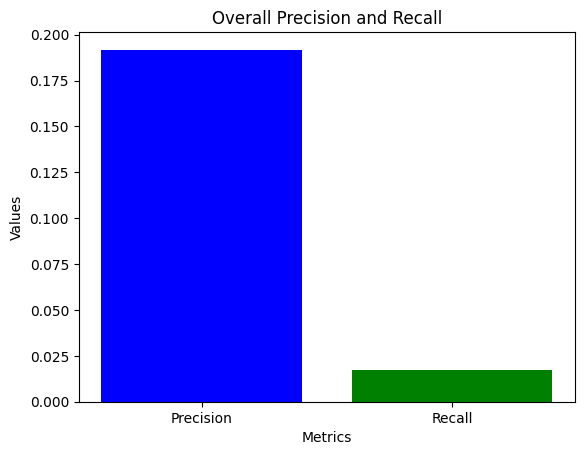

In [ ]:
import matplotlib.pyplot as plt

# Function to calculate precision and recall for overall recommendations
def calculate_precision_recall(ratings_df, recommended_movies, n_recommendations=5):
    # Initialize lists to store precision and recall
    precision_list = []
    recall_list = []

    # Iterate over each user
    for user_id in ratings_df['userId'].unique():
        # Get movies rated by the user
        actual_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        # Get recommended movies for the user
        recommended_movies_user = recommend_movies(user_id, ratings_df, movies_tags_df, cosine_sim, n_recommendations)

        # Limit the number of recommended movies for precision calculation
        recommended_movies_user = recommended_movies_user[:n_recommendations // 3]

        # Calculate intersection between actual and recommended movies
        intersection = len(set(actual_movies) & set(recommended_movies_user))

        # Calculate precision and recall
        precision = intersection / n_recommendations
        recall = intersection / len(actual_movies)

        # Add precision and recall to lists
        precision_list.append(precision)
        recall_list.append(recall)

    return precision_list, recall_list

# Calculate precision and recall for overall recommendations
precision_list, recall_list = calculate_precision_recall(ratings_df, recommended_movies)

# Calculate overall precision and recall
overall_precision = sum(precision_list) / len(precision_list)
overall_recall = sum(recall_list) / len(recall_list)

# Plot bar graph for precision and recall
labels = ['Precision', 'Recall']
values = [overall_precision, overall_recall]

plt.bar(labels, values, color=['blue', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Overall Precision and Recall')
plt.show()
